# n-armed Bandit

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from matplotlib import pyplot as plt

A `bandit` is a slot machine with *n* arms. When an arm is *pulled* a random reward is drawn from a normal distribution with different mean *m* and variance = `1`

Pulling an arm does not change the state of the system yet. We'll consider bandits with state later.

In [2]:
# Initialize the random pool
seed = 65432874
rand = np.random.RandomState(seed)

# bandits' mean values
bandits = [0.5, 2.15, 1.02, 0.44, -1.6, 1.45, -0.62, 1.9, -1.16, 0.63]

def pull_bandit(bandit):
    return rand.normal(bandits[bandit], 1)   # choose from normal dist, with mean from bandit
                                             # and sigma = 1 (thus variance=1)

We define an class `AgentsState` that holds the learning state at a given time. This way we can re-run the algorithm easily with different parameters. 

Another alternative is defining the variables in the global scope, but this is easier.

In [3]:
class AgentsState(object):
    
    def __init__(self, bandits):
        self.n = len(bandits)
        
        self.q = np.zeros(self.n)     # total reward of doing a specific action: Q(a)
        self.n_a = np.zeros(self.n)   # number of times (action) a chosen 
        self.q_t = np.zeros(self.n)   # average reward of action
        
        self.r_total = 0.0             # total reward accumulated
        self.r_avg = None              # average reward per step

The `learn` method below updates the state with the `reward` that it just received from the environment in response to the `action`. 

In this case, we only remember the action we made and the reward that particular action gave us.

In [4]:
def learn(state, action, reward, step):
    state.r_total += reward
    state.r_avg[step] = state.r_total / step
    
    state.n_a[action] += 1
    state.q[action] += reward
    state.q_t[action] = state.q[action] / state.n_a[action]

Now, for a number of steps, we decide on our next action using our current state, Then, we perform the action and get a numerical reward from the environment. Using the reward, we update our state w.r.t the action we just did. 

`run` function expects the `next_action` function and which is run on each iteration. We can provide different ways of choosing our next action without changing the `run` function now.

In [5]:
def run(state, num_steps, next_action):
    state.r_total = 0.0
    state.r_avg = np.zeros(num_steps)
    
    for step in range(1, num_steps):
        action = next_action(state)
        reward = pull_bandit(action)
        # learn from the state, reward, action
        learn(state, action, reward, step)

$\epsilon$-greedy choose

In [6]:
def act_e_greedy(state, eps):
    '''eps-greedy choose'''
    _qi = list(range(state.n))
    if rand.random_sample() > eps:
        # find the 
        _qi = np.argwhere(state.q_t == np.amax(state.q_t)).flatten()
        if (len(_qi) == 1):
            return _qi[0]
    
    return _qi[rand.randint(0, len(_qi))]

Put it all together and run for $\epsilon$ = 0.1 and $\epsilon$ = 0.01 

In [7]:
num_steps = 2000

s_e1 = AgentsState(bandits)
run(s_e1, num_steps, lambda x: act_e_greedy(x, 0.1))

rand = np.random.RandomState(seed)     # re-initialize the RNG

s_e2 = AgentsState(bandits)
run(s_e2, num_steps, lambda x: act_e_greedy(x, 0.01))

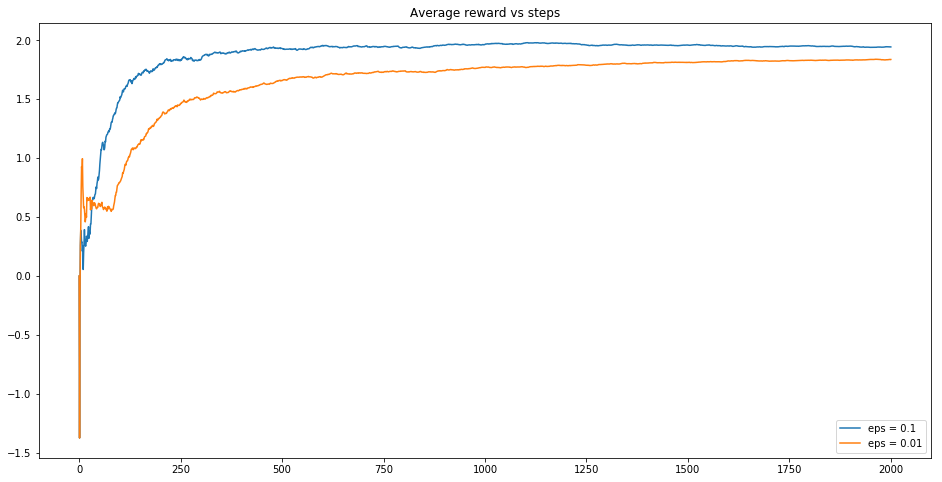

In [8]:
x = np.linspace(0, num_steps, num=num_steps)
plt.figure(figsize=(16, 8))
plt.plot(x, s_e1.r_avg, label='eps = 0.1')
plt.plot(x, s_e2.r_avg, label='eps = 0.01')
plt.title('Average reward vs steps')
plt.legend(loc='lower right')
plt.show()

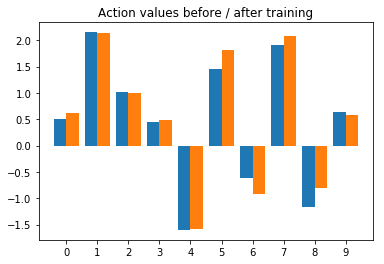

In [9]:
nx = np.arange(len(bandits))
plt.bar(nx, bandits, width=0.4)
plt.bar(nx + 0.4, s_e1.q_t, width=0.4)
plt.xticks(nx + 0.2, nx)
plt.title('Action values before / after training')
plt.show()